## Import

In [1]:
import sys
sys.path.append(r'C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [2]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
# Ignore the ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [24]:
import io
import pytz
import folium
import pyproj
import numpy as np
import pickle as pkl
from PIL import Image
import networkx as nx
import geopandas as gpd
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from urllib.request import urlopen, Request
from matplotlib.animation import FuncAnimation
from mongo_db import retrieve_database_and_collections
from networkx.drawing.nx_agraph import graphviz_layout
from convert_geometry import toMultiLineString, toExtremePoints

## Retrieve collection and convert to a dataframe

In [4]:
day = "20_04_2023"

In [5]:
with open(rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\{day}.geojson", "rb") as f:
    gdf = pkl.load(f)

In [6]:
gdf = gdf.set_geometry("geometry.extreme_point")

## Data preparation

### Find unique identifier for road segments

In [7]:
for date in gdf["api_call_time"].unique():
    sub_gdf = gdf[gdf["api_call_time"] == date]
    key = sub_gdf["geometry.extreme_point"]
    print(date, len(sub_gdf), len(key.unique()), len(sub_gdf)-len(key.unique()))

2023-04-20 13:00:00+00:00 620 616 4
2023-04-20 13:05:00+00:00 622 618 4
2023-04-20 13:10:00+00:00 624 620 4
2023-04-20 13:15:00+00:00 626 622 4
2023-04-20 13:20:00+00:00 624 620 4
2023-04-20 13:25:00+00:00 625 621 4
2023-04-20 13:30:00+00:00 623 619 4
2023-04-20 13:35:00+00:00 620 616 4
2023-04-20 13:40:00+00:00 623 619 4
2023-04-20 13:45:00+00:00 623 619 4
2023-04-20 13:50:00+00:00 627 623 4
2023-04-20 13:55:00+00:00 621 617 4
2023-04-20 14:00:00+00:00 628 624 4
2023-04-20 14:05:00+00:00 624 620 4
2023-04-20 14:10:00+00:00 625 621 4
2023-04-20 14:15:00+00:00 623 619 4
2023-04-20 14:20:00+00:00 625 621 4
2023-04-20 14:25:00+00:00 622 618 4
2023-04-20 14:30:00+00:00 625 621 4
2023-04-20 14:35:00+00:00 622 618 4
2023-04-20 14:40:00+00:00 622 618 4
2023-04-20 14:45:00+00:00 623 619 4
2023-04-20 14:50:00+00:00 623 619 4
2023-04-20 14:55:00+00:00 626 622 4
2023-04-20 15:00:00+00:00 624 620 4
2023-04-20 09:00:00+00:00 619 615 4
2023-04-20 09:05:00+00:00 620 616 4
2023-04-20 09:10:00+00:00 62

In [8]:
for date in list(gdf["api_call_time"].unique()):
    sub_gdf = gdf[(gdf["api_call_time"] == date)]
    vc = sub_gdf["geometry.extreme_point"].value_counts(sort=False)
    sub_sub_gdf = sub_gdf[sub_gdf["geometry.extreme_point"].isin(vc[vc > 1].index)]
    for geometry in sub_sub_gdf["geometry.extreme_point"].unique():
        print("the description field is different: ", len(sub_sub_gdf[sub_sub_gdf["geometry.extreme_point"] == geometry]["description"].unique())>1)
        if len(sub_sub_gdf[sub_sub_gdf["geometry.extreme_point"] == geometry]["description"].unique())<2:
            print(date)
            break

the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different:  True
the description field is different

From the previous cells we observe that the tuple ("description, "geometry") is unique for each road segment. We can therefore use this tuple as a unique identifier for each road segment. 

### Take average value in each road segment for each gdf

In [9]:
gdf.columns

Index(['sourceUpdated', 'api_call_time', 'description', 'length',
       'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence', 'currentFlow.traversability', 'geometry.type',
       'currentFlow.jamTendency', 'currentFlow.junctionTraversability',
       'geometry.multi_line', 'geometry.extreme_point'],
      dtype='object')

In [10]:
gdf_average = gdf.groupby(["description", "geometry.extreme_point"], sort=False, dropna=False)[['length',
       'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()

In [11]:
gdf_average

,description,geometry.extreme_point,length,currentFlow.speed,currentFlow.speedUncapped,currentFlow.freeFlow,currentFlow.jamFactor,currentFlow.confidence
0,Herland,"MULTIPOINT (5.53747 60.42335, 5.53903 60.42214)",374.0,12.993828,12.993828,16.111110,1.611111,0.734286
1,Herland,"MULTIPOINT (5.53492 60.42177, 5.53757 60.42317)",313.0,15.136685,15.149912,15.000000,0.168254,0.803333
2,Takvam,"MULTIPOINT (5.53492 60.42177, 5.51596 60.42212)",1173.0,19.206350,19.519401,19.444445,0.100000,0.909048
3,Takvam,"MULTIPOINT (5.51612 60.42207, 5.51624 60.42231)",31.0,5.965609,5.965609,8.611112,2.395238,0.719048
4,Takvam,"MULTIPOINT (5.46050 60.42195, 5.51596 60.42212)",8122.0,11.141976,11.141976,12.222222,0.733333,0.842540
...,...,...,...,...,...,...,...,...
671,Smedneset,"MULTIPOINT (5.26722 60.50718, 5.26710 60.50710)",12.0,4.149030,4.149030,4.166667,0.000000,0.700635
672,Smedneset,"MULTIPOINT (5.26737 60.50590, 5.26722 60.50718)",146.0,4.532628,4.532628,5.277778,0.685714,0.708571
673,Salhus,"MULTIPOINT (5.26710 60.50710, 5.26737 60.50590)",134.0,5.868607,5.868607,7.777778,2.115873,0.700635
674,Salhus,"MULTIPOINT (5.26737 60.50590, 5.26773 60.50591)",20.0,7.716050,7.716050,7.777778,0.074603,0.711746


##### Check for the presence of NaN values

In [12]:
gdf_average[gdf_average.isna().apply(lambda x: x["currentFlow.speedUncapped"], axis=1)]

,description,geometry.extreme_point,length,currentFlow.speed,currentFlow.speedUncapped,currentFlow.freeFlow,currentFlow.jamFactor,currentFlow.confidence
66,NaN,"MULTIPOINT (5.28976 60.29086, 5.29016 60.29079)",24.0,NaN,NaN,0.000000,10.0,NaN
67,NaN,"MULTIPOINT (5.29016 60.29079, 5.29048 60.29037)",58.0,NaN,NaN,0.000000,10.0,NaN
68,NaN,"MULTIPOINT (5.29048 60.29037, 5.29046 60.29013)",27.0,NaN,NaN,0.000000,10.0,NaN
199,NaN,"MULTIPOINT (5.33799 60.32356, 5.34689 60.31863)",1374.0,NaN,NaN,7.222222,10.0,NaN
200,NaN,"MULTIPOINT (5.33952 60.31717, 5.33961 60.31630)",106.0,NaN,NaN,0.000000,10.0,NaN
316,Myraskjenet,"MULTIPOINT (5.21953 60.34025, 5.19267 60.34695)",3273.0,NaN,NaN,12.222222,10.0,NaN
341,Nyborg,"MULTIPOINT (5.19267 60.34695, 5.19708 60.37056)",2727.0,NaN,NaN,12.222222,10.0,NaN


##### Delete NaN values

In [13]:
gdf_average.dropna(subset=["currentFlow.speedUncapped"], inplace=True)

In [14]:
gdf_average[gdf_average.isna().apply(lambda x: x["currentFlow.speedUncapped"], axis=1)]

,description,geometry.extreme_point,length,currentFlow.speed,currentFlow.speedUncapped,currentFlow.freeFlow,currentFlow.jamFactor,currentFlow.confidence


## Build average graph

In [15]:
mapping = {}

for i, col in enumerate(gdf.columns):
    mapping[col] = i

In [16]:
G = nx.DiGraph()

for row in gdf.values:
    p0 = row[mapping["geometry.extreme_point"]][0]
    p1 = row[mapping["geometry.extreme_point"]][1]
    t0 = tuple([p0.coords.xy[0][0], p0.coords.xy[1][0]])
    t1 = tuple([p1.coords.xy[0][0], p1.coords.xy[1][0]])
    speed = row[mapping["currentFlow.speedUncapped"]]
    length = row[mapping["length"]]
    description = row[mapping["description"]]
    
    G.add_edge(t0, t1, weight=speed, length=length, description=description)

In [17]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [18]:
cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

In [19]:
osm_img.crs

<Bound CRS: +proj=merc +a=6378137.0 +b=6378137.0 +nadgrids=@nu ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84
- method: NTv2
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unknown

In [22]:
# Define source CRS (WGS84)
wgs84_crs = pyproj.CRS("EPSG:4326")
# Create transformer object
transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
# Transform coordinates
pos = {node : transformer.transform(node[1], node[0]) for node in G.nodes()}

Text(0.5, 1.0, 'Bergen road network')

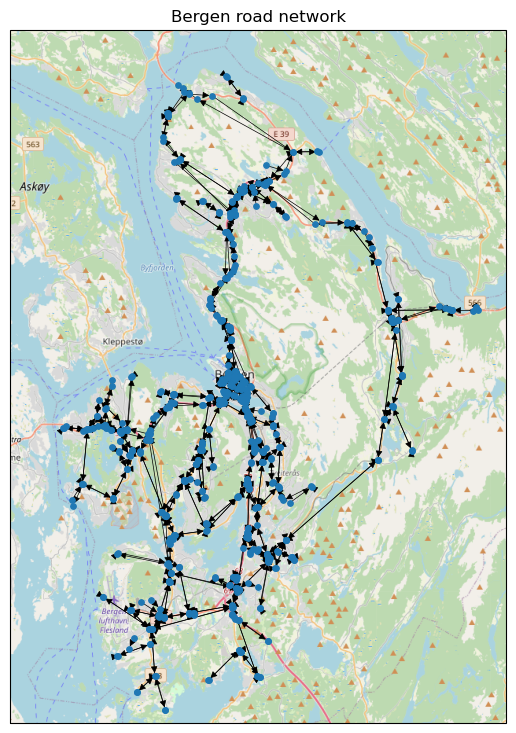

In [25]:
fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
zoom = 0.15 # for zooming out of center point
extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax.add_image(osm_img, int(scale))

nx.draw_networkx(G, pos=pos, 
                 node_size=15,
                 ax=ax,
                 width=0.5,
                 arrows=True,
                 with_labels = False)

ax.set_title('Bergen road network')


#### Weak connection

In [1]:
nx.number_weakly_connected_components(G)

NameError: name 'nx' is not defined

In [29]:
weakly_cc =  [c for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]

In [30]:
CC = []
for cc in weakly_cc:
    nodes = [tuple([node[0], node[1]]) for node in cc]
    CC.append(nx.DiGraph())
    for node1 in nodes:
        for node2 in nodes:
            if G.has_edge(node1, node2):
                CC[-1].add_edge(node1, node2)

In [31]:
# Define source CRS (WGS84)
wgs84_crs = pyproj.CRS("EPSG:4326")
# Create transformer object
transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)
# Transform coordinates
positions = []
for cc in CC:
    try:
        positions.append({node : transformer.transform(node[1], node[0]) for node in cc.nodes()})
    except:
        print(cc.nodes())

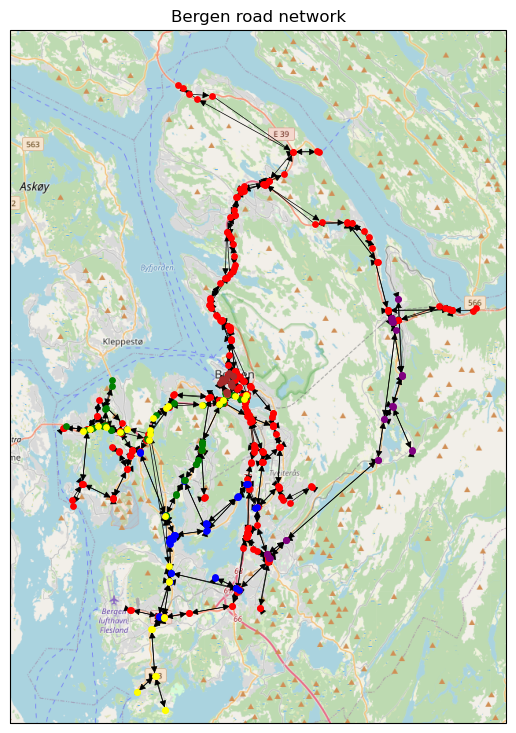

In [32]:
fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
zoom = 0.15 # for zooming out of center point
extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax.add_image(osm_img, int(scale))

ax.set_title('Bergen road network')

colors = ["red", "blue", "green", "yellow", "purple", "brown"]
n = len(colors)

for cc, pos, col in zip(CC[:n], positions[:n], colors[:n]):
    nx.draw_networkx(cc, pos=pos, 
                 node_size=15,
                 ax=ax,
                 width=0.5,
                 arrows=True,
                 node_color=col,
                 with_labels = False)

In [ ]:
# OpenStreetMap
map = folium.Map(location=center_pt, tiles="OpenStreetMap", zoom_start=11)
for cc, pos, col in zip(CC[:n], positions[:n], colors[:n]):
    for node in cc.nodes():
        folium.Circle([node[1], node[0]], radius=1, color=col).add_to(map)
        #folium.PolyLine([[node[1], node[0]], [node[1], node[0]]], color=col).add_to(map)
map